## Device maintenance Task
Given a data set containing data collected from sensors that are monitoring a  
certain device a stakeholder perceived the need to improve the maintenance  
of this device.  


He approached you and described the Business case as:  
We have this data and I understand that we need to improve the way we  
schedule the maintenance for this device, can you assess this data and create  
an AI solution for it?  


The data is composed of 53 features and 1 Class.  
One of the features is a timestamp, the others are sensor observations.  
Can you help me to improve the maintenance somehow?  
You should prepare the code and a short presentation (10 minutes max)  
explaining your approach and why you decided to use the chosen approach.  

### Deliverables:
Code in an exported notebook  
Presentation

In [ ]:
# !pip install -q -U umap-learn
# !pip install imbalanced-learn
# ! pip install statsmodels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, balanced_accuracy_score, confusion_matrix, f1_score
import random
import json
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
import utils
pd.set_option('display.max_rows', 60)
%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv('data/DATA.csv', index_col=0)
print(df.shape)
df.head()

(220320, 54)


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [3]:
df.isnull().sum().sort_values(ascending=False)

sensor_15         220320
sensor_50          77017
sensor_51          15383
sensor_00          10208
sensor_07           5451
sensor_08           5107
sensor_06           4798
sensor_09           4595
sensor_01            369
sensor_30            261
sensor_29             72
sensor_32             68
sensor_18             46
sensor_17             46
sensor_22             41
sensor_25             36
sensor_16             31
sensor_49             27
sensor_48             27
sensor_47             27
sensor_46             27
sensor_45             27
sensor_44             27
sensor_43             27
sensor_42             27
sensor_41             27
sensor_40             27
sensor_39             27
sensor_38             27
sensor_14             21
sensor_26             20
sensor_03             19
sensor_10             19
sensor_13             19
sensor_12             19
sensor_11             19
sensor_05             19
sensor_04             19
sensor_02             19
sensor_36             16


In [4]:
# Drop empty column
df.drop(["sensor_15"], axis = 1, inplace = True)

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [6]:
# np.unique(df["timestamp"].dt.date).shape, Counter(df["timestamp"].dt.date)

In [7]:

df.set_index('timestamp', inplace=True)

In [8]:
cols = df.columns[:-1]
print(len(cols), cols)

51 Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14',
       'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
       'sensor_21', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25',
       'sensor_26', 'sensor_27', 'sensor_28', 'sensor_29', 'sensor_30',
       'sensor_31', 'sensor_32', 'sensor_33', 'sensor_34', 'sensor_35',
       'sensor_36', 'sensor_37', 'sensor_38', 'sensor_39', 'sensor_40',
       'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45',
       'sensor_46', 'sensor_47', 'sensor_48', 'sensor_49', 'sensor_50',
       'sensor_51'],
      dtype='object')


# Target variable
Data is highly imbalanced

In [9]:
df["machine_status"].value_counts()

machine_status
NORMAL         205836
MAINTENANCE     14477
BROKEN              7
Name: count, dtype: int64

In [10]:
df, cols = utils.preprocess(df)

# Filtering
Remove maintenance and last normal period


In [11]:
df = df[df["machine_status"] != "MAINTENANCE"]
print(df.shape)

(205843, 54)


In [12]:
df = df[df['idx'] <= df[df["machine_status"] == "BROKEN"]["idx"].values[-1]]
print(df.shape)
df['idx'] = np.arange(df.shape[0])

(152039, 54)


In [ ]:
# cols = cols[[0,4,5,6,7,8,9]]
# extra_cols = []
# for c in cols:
#     df[f'rm{c}'] = df[f'{c}'].rolling(window=100, min_periods = 1).mean()
#     df[f'shifted{c}'] = df[f'rm{c}'].shift(100)
#     extra_cols.append(f'rm{c}')
#     extra_cols.append(f'shifted{c}')

# cols = np.concatenate([cols, extra_cols])
# print(cols)

# Create survival columns

In [13]:
prev = 0
survival = np.zeros(df.shape[0])
incident = np.zeros(df.shape[0])
broken_idx = df[df['y'] == 0]['idx'].values
for ii, i in enumerate(broken_idx):
    survival[prev:i+1] = np.arange(i-prev+1)[::-1]
    incident[prev:i+1] = np.ones(i-prev+1) * ii
    prev = i + 1
df['survival'] = survival.astype(int)
df['incident_nb'] = incident.astype(int)

In [14]:
df['incident_nb'].value_counts()

incident_nb
4    49645
2    41698
6    25268
0    17156
3     7160
1     6411
5     4701
Name: count, dtype: int64

# Dataset creation for training

In [15]:
df.set_index(np.arange(len(df)), inplace = True)

In [20]:
prediction_horizon = 1400
window_size = 1
X, y_reg, y_classif, incident_ref, idx_ref = utils.prepare_dataset(df, cols, window_size,  
                                                                   prediction_horizon, autocorr_window = 10)

print(X.shape, y_reg.shape, Counter(y_classif))

(15207, 51, 1) (15207,) Counter({0: 14227, 1: 980})


In [21]:
model, f1, cm = utils.classification(X, y_classif, random_state=1)

# Feature importance

In [22]:
# Assuming that 'model' is your trained XGBoost model
# xgb.plot_importance(model)
# plt.rcParams['figure.figsize'] = [20, 10]
# plt.show()

In [23]:
model, mae = utils.regression(X, y_reg, y_classif, random_state=1)
print(mae)

4514.5285079390915


# Simulation loop


In [24]:
res = pd.DataFrame(columns=["window","prediction horizon","f1", "mae", "cm", "n_samples"])
window_sizes = [1, 2, 10, 20]
prediction_horizons = [100,  300, 700, 1000, 1400]

In [25]:
for window_size in window_sizes:
    for prediction_horizon in prediction_horizons:
        for random_state in range(1, 3):
            print(window_size, prediction_horizon)
            X, y_reg, y_classif, incident_ref, idx_ref = utils.prepare_dataset(df, cols, window_size,  prediction_horizon, autocorr_window = 10)
            model, f1, cm = utils.classification(X, y_classif, random_state=random_state)
            model, mae = utils.regression(X, y_reg, y_classif, random_state=random_state)
            res.loc[res.shape[0]] = [window_size, prediction_horizon, f1, mae, cm, X.shape]

1 100
1 100
1 300
1 300
1 700
1 700
1 1000
1 1000
1 1400
1 1400
2 100
2 100
2 300
2 300
2 700
2 700
2 1000
2 1000
2 1400
2 1400
10 100
10 100
10 300
10 300
10 700
10 700
10 1000
10 1000
10 1400
10 1400
20 100
20 100
20 300
20 300
20 700
20 700
20 1000
20 1000
20 1400
20 1400


In [ ]:
# res

In [32]:
pd.DataFrame(matrix)

,0
0,4582.05
1,4698.11
2,4557.00
3,4561.96


Text(0.5, 1.0, 'Mean MAE score')

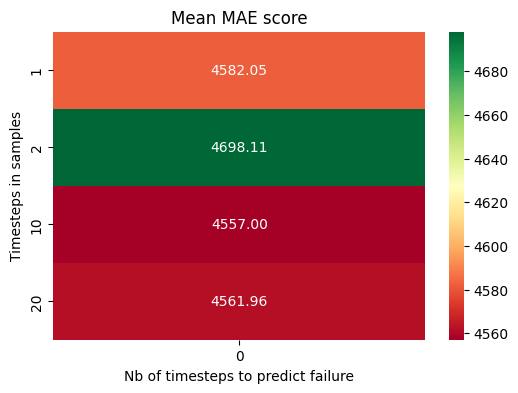

In [37]:
matrix = res.groupby(["window"]).agg({"mae":"mean"}).unstack().round(2).values
matrix = pd.DataFrame(matrix)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap='RdYlGn', yticklabels=window_sizes, annot=True, fmt=".2f")
plt.xlabel('Nb of timesteps to predict failure')
plt.ylabel('Timesteps in samples')
plt.title('Mean MAE score')

Text(0.5, 1.0, 'Mean F1 score')

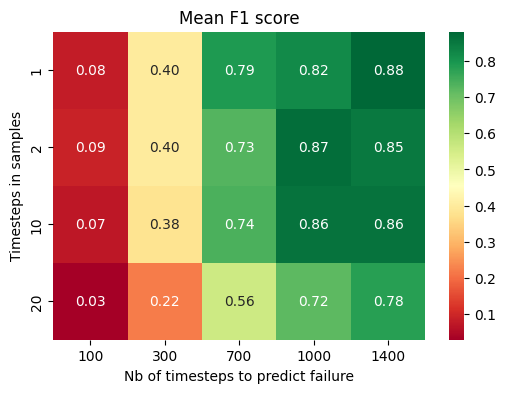

In [29]:
matrix = res.groupby(["window","prediction horizon"]).agg({"f1":"mean"}).unstack().round(2).values
plt.figure(figsize=(6, 4))
sns.heatmap(matrix, cmap='RdYlGn', xticklabels=prediction_horizons, yticklabels=window_sizes, annot=True, fmt=".2f")
plt.xlabel('Nb of timesteps to predict failure')
plt.ylabel('Timesteps in samples')
plt.title('Mean F1 score')


# Classification

In [45]:
X, y_reg, y_classif, incident_ref, idx_ref = utils.prepare_dataset(df, cols, 2,  1400, autocorr_window = 8)
print(X.shape)

(19008, 51, 2)


In [46]:
# unique_incidents = np.unique(incident_ref)
# _, _, Y_train, Y_test = train_test_split(np.arange(len(unique_incidents)), 
#     unique_incidents, test_size=0.2, random_state=10)
# Y_train = [0, 1, 2, 3, 5, 6]
# Y_test = [4]
# print(Y_train, Y_test)

# idx_train = np.where(np.in1d(incident_ref, Y_train))[0]
# idx_test = np.where(np.in1d(incident_ref, Y_test))[0]
# print(idx_test.shape, idx_train.shape)
# print(len(idx_train), len(idx_test), Counter(incident_ref[idx_test]))

# y_classif_train = y_classif[idx_train]
# print(Counter(y_classif_train))
# c0_idx_train = idx_train[np.where(y_classif_train == 1)[0]]

# c1_idx_train = idx_train[random.sample(list(np.where(y_classif_train == 0)[0]), int(len(c0_idx_train) *1.2))]
# print(len(c0_idx_train),  len(c1_idx_train))

# idx_train = np.concatenate([c0_idx_train, c1_idx_train])
# print(len(idx_train))

In [47]:
idx_train, idx_test, Y_train, Y_test = train_test_split(np.arange(len(y_classif)), 
    y_classif, test_size=0.3, random_state=0, stratify=y_classif)
print(Counter(Y_train), Counter(Y_test))

c0_idx_train = idx_train[np.where(Y_train == 1)[0]]
c1_idx_train = idx_train[random.sample(list(np.where(Y_train == 0)[0]), int(len(c0_idx_train) *1.5))]
print(len(c0_idx_train),  len(c1_idx_train))

idx_train = np.concatenate([c0_idx_train, c1_idx_train])
print(len(idx_train))

Counter({0: 12448, 1: 857}) Counter({0: 5335, 1: 368})
857 1285
2142


In [48]:
class_weights = len(idx_train) / np.bincount(y_classif[idx_train])
print(class_weights)
class_weights[1] = 2* class_weights[1]
print(class_weights)
train_weights = [class_weights[i] for i in y_classif[idx_train]]
model = XGBClassifier()
model.fit(X[idx_train].reshape(len(idx_train), -1), y_classif[idx_train],
sample_weight=train_weights
);

[1.66692607 2.49941657]
[1.66692607 4.99883314]


In [49]:
preds = model.predict(X[idx_test].reshape(len(idx_test), -1))
true = y_classif[idx_test]
print(Counter(preds))
f1 = f1_score(true, preds)
cm = confusion_matrix(true, preds)
print('F1: ', f1)
print('Recall: ', recall_score(true, preds, average='weighted'))
print('Precision: ', precision_score(true, preds, average='weighted'))
print('Balanced Accuracy: ', balanced_accuracy_score(true, preds))
print('Confusion Matrix: \n', cm)

Counter({0: 5220, 1: 483})
F1:  0.8460634547591069
Recall:  0.9770296335262143
Precision:  0.9821338714843042
Balanced Accuracy:  0.9776027871724868
Confusion Matrix: 
 [[5212  123]
 [   8  360]]


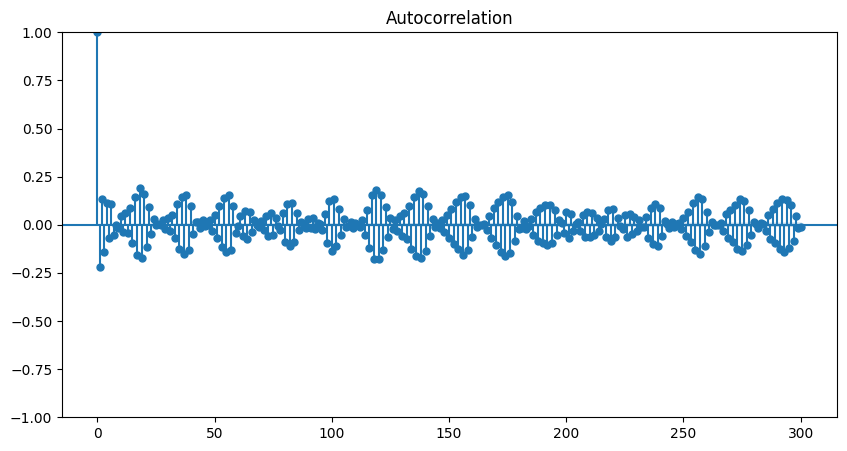

In [28]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
data = df["sensor_00"].values



model = AutoReg(data, lags=1)
model_fit = model.fit()

plt.figure(figsize=(10, 5))
# Plot the partial autocorrelation plot
sm.graphics.tsa.plot_acf(model_fit.resid, lags=300, ax = plt.gca())
plt.show()

# Regression

In [ ]:
idx_train, idx_test, Y_train, Y_test = train_test_split(np.arange(len(y_classif)), 
    y_classif, test_size=0.3, random_state=1, stratify=y_classif)
print(Counter(Y_train), Counter(Y_test), len(idx_train), len(idx_test))

In [ ]:
# Create a DMatrix for more efficiency
dtrain = xgb.DMatrix(X[idx_train].reshape(len(idx_train), -1), label=y_reg[idx_train])
dtest = xgb.DMatrix(X[idx_test].reshape(len(idx_test), -1), label=y_reg[idx_test])

# Define the parameters
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'reg:squarederror',  # error function for regression
    'eval_metric': 'rmse'  # evaluation metric for regression
}
num_round = 10  # the number of training iterations

# Train the model
bst = xgb.train(param, dtrain, num_round)



In [ ]:
np.mean(y_reg[idx_test])

In [ ]:
# Make prediction
preds = bst.predict(dtest)
true = y_reg[idx_test]

In [ ]:
mean_absolute_error(true, preds)